<a href="https://colab.research.google.com/github/ajaycode/machine-learning/blob/main/Humidity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Analysis of humidity data*

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [10]:
# Load the dataset
df = pd.read_csv("humidity-data.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
df.head()

,Time,Temperature (Fahrenheit),Relative_Humidity
0,7/3/2020 15:51:00,70.52,54.6
1,7/3/2020 15:52:00,70.7,53.2
2,7/3/2020 15:53:00,71.06,57.1
3,7/3/2020 15:54:00,71.06,52.9
4,7/3/2020 15:55:00,71.24,52.8


In [13]:
# Convert timestamp column to datetime and set it as the index
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df.set_index('timestamp', inplace=True)


df['Temperature (Fahrenheit)'] = pd.to_numeric(df['Temperature (Fahrenheit)'], errors='coerce')
df['Relative_Humidity'] = pd.to_numeric(df['Relative_Humidity'], errors='coerce')

TypeError: ignored

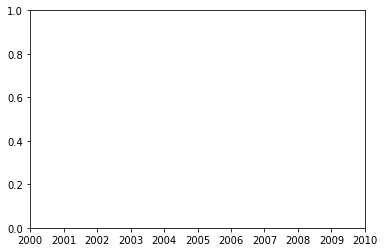

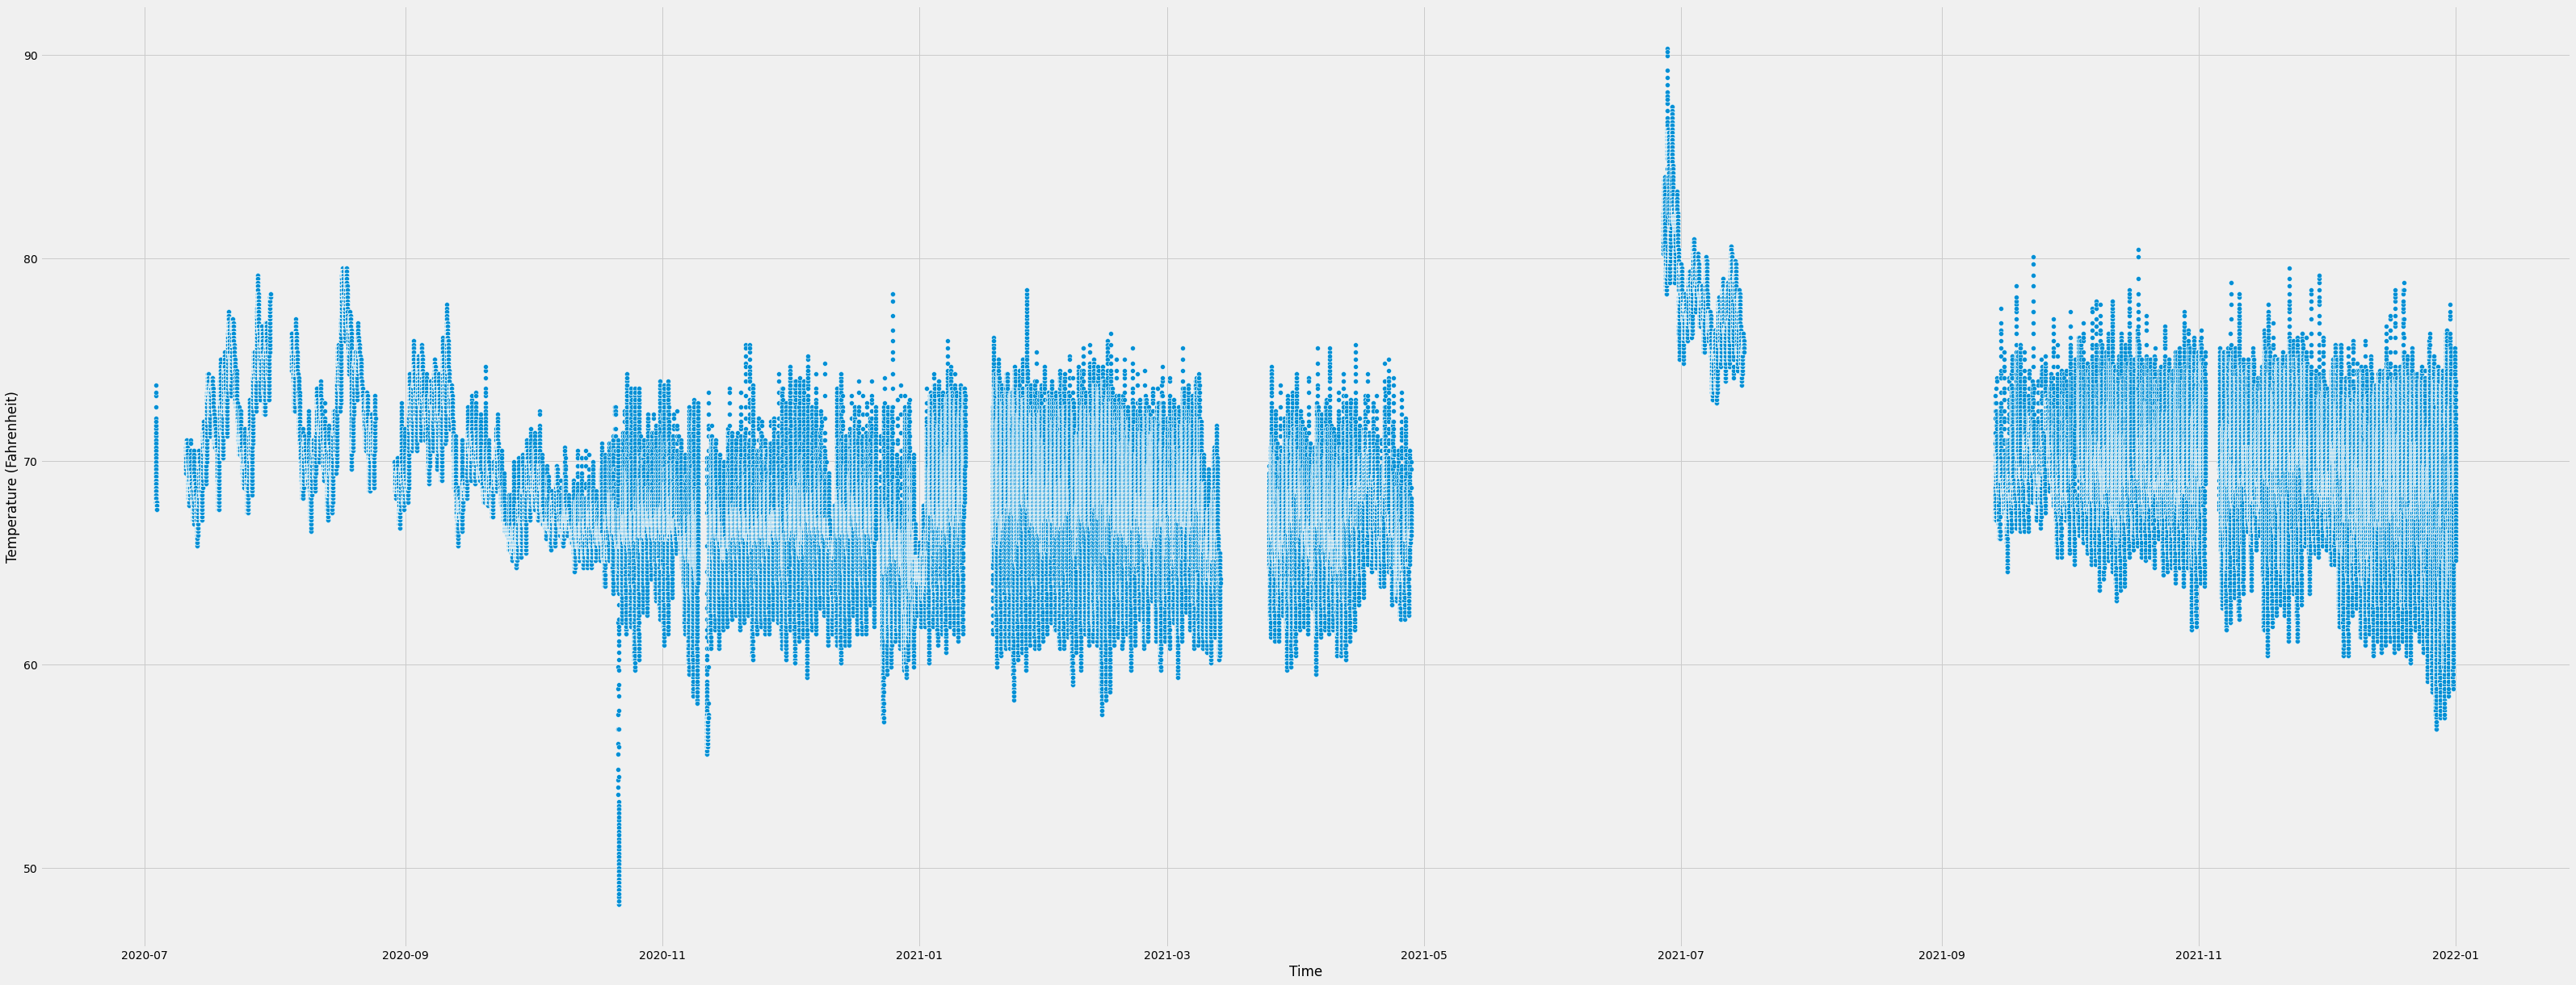

In [16]:
plt.figure (figsize=(50, 20))
sns.scatterplot(x=df['Time'], y=df['Temperature (Fahrenheit)'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: ignored

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


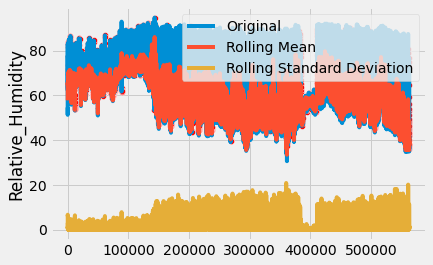

In [24]:
# Create rolling mean and standard deviation
rolling_mean = df['Relative_Humidity'].rolling(window=60).mean()
rolling_std = df['Relative_Humidity'].rolling(window=60).std()

# Identify data points that fall outside of 3 standard deviations from the mean
anomalies = df[(df['Relative_Humidity'] > rolling_mean + 3*rolling_std) | (df['Relative_Humidity'] < rolling_mean - 3*rolling_std)]

# Plot the original data along with the rolling mean and standard deviation
plt.plot(df['Relative_Humidity'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Standard Deviation')
plt.legend()

# Highlight the identified anomalies
plt.scatter(anomalies.index, anomalies['Relative_Humidity'], color='r')
plt.show()


In [21]:
# Determine min/max humidity per day
# Create a new column with the date
df['date'] = df['Time'].dt.date

# Group the data by date and calculate the min and max humidity per day
min_max_humidity = df.groupby('date')['Relative_Humidity'].agg(['min', 'max'])

print(min_max_humidity)

             min   max
date                  
2020-07-03  51.3  83.0
2020-07-10  62.7  77.7
2020-07-11  63.0  83.6
2020-07-12  63.3  85.1
2020-07-13  62.2  86.5
...          ...   ...
2021-12-27  34.7  69.5
2021-12-28  35.1  48.2
2021-12-29  34.8  64.2
2021-12-30  35.6  87.4
2021-12-31  34.9  76.6

[395 rows x 2 columns]


In [28]:
# Calculate the number of deviations from baseline to max humidity and back
# Calculate the duration of each window baseline -> max -> baseline +/- 2

# Group the data by date
grouped_df = df.groupby(pd.Grouper(key='Time', freq='D'))

# Initialize a list to store the results
results = []

# Iterate through each group (i.e. each date)
for name, group in grouped_df:
    # Calculate the baseline relative humidity for this day
    baseline_rh = group['Relative_Humidity'].mean()

    # Initialize variables to store the start and end times of the deviation from baseline
    start_time = None
    end_time = None

    # Initialize a variable to track if we are currently in a deviation from baseline
    deviation = False

    # Initialize variable to track the max humidity
    max_humidity = -1

    # Initialize a variable to count the number of deviations
    deviation_count = 0

    # Iterate through the data for this group
    for i, row in group.iterrows():
        # If the current relative humidity is within 2 degrees of the baseline and we haven't already detected a deviation
        if abs(row['Relative_Humidity'] - baseline_rh) < 2 and not deviation:
            # Update the start time, set deviation to True, and increment the deviation count
            start_time = row['Time']
            deviation = True
            deviation_count += 1
        # If the current relative humidity is above the max_humidity
        if row['Relative_Humidity'] > max_humidity:
            max_humidity = row['Relative_Humidity']
            max_time = row['Time']
        # If the current relative humidity is back at the baseline and we had previously detected a deviation
        elif abs(row['Relative_Humidity'] - baseline_rh) >= 2 and deviation:
            # Update the end time, set deviation to False
            end_time = row['Time']
            deviation = False
    if end_time is not None:
        deviation_duration = (end_time-start_time).seconds
    else:
        deviation_duration = None
    results.append([name.date(), start_time, end_time, max_time, deviation_count, deviation_duration])

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=["Date", "Start Time", "End Time", "Max Time", "Deviation Count", "Duration"])

# Print the table
print(df_results)


           Date          Start Time            End Time            Max Time  \
0    2020-07-03 2020-07-03 18:48:00 2020-07-03 20:08:00 2020-07-03 17:21:00   
1    2020-07-04                 NaT                 NaT 2020-07-03 17:21:00   
2    2020-07-05                 NaT                 NaT 2020-07-03 17:21:00   
3    2020-07-06                 NaT                 NaT 2020-07-03 17:21:00   
4    2020-07-07                 NaT                 NaT 2020-07-03 17:21:00   
..          ...                 ...                 ...                 ...   
542  2021-12-27 2021-12-27 23:31:00 2021-12-27 18:28:00 2021-12-27 10:59:00   
543  2021-12-28 2021-12-28 22:07:00 2021-12-28 22:06:00 2021-12-28 07:01:00   
544  2021-12-29 2021-12-29 21:58:00 2021-12-29 21:36:00 2021-12-29 13:11:00   
545  2021-12-30 2021-12-30 22:02:00 2021-12-30 20:47:00 2021-12-30 15:36:00   
546  2021-12-31 2021-12-31 22:10:00 2021-12-31 20:42:00 2021-12-31 18:03:00   

     Deviation Count  Duration  
0                 

In [41]:
df_results.dtypes

Date                       object
Start Time         datetime64[ns]
End Time           datetime64[ns]
Max Time           datetime64[ns]
Deviation Count             int64
Duration                  float64
dtype: object

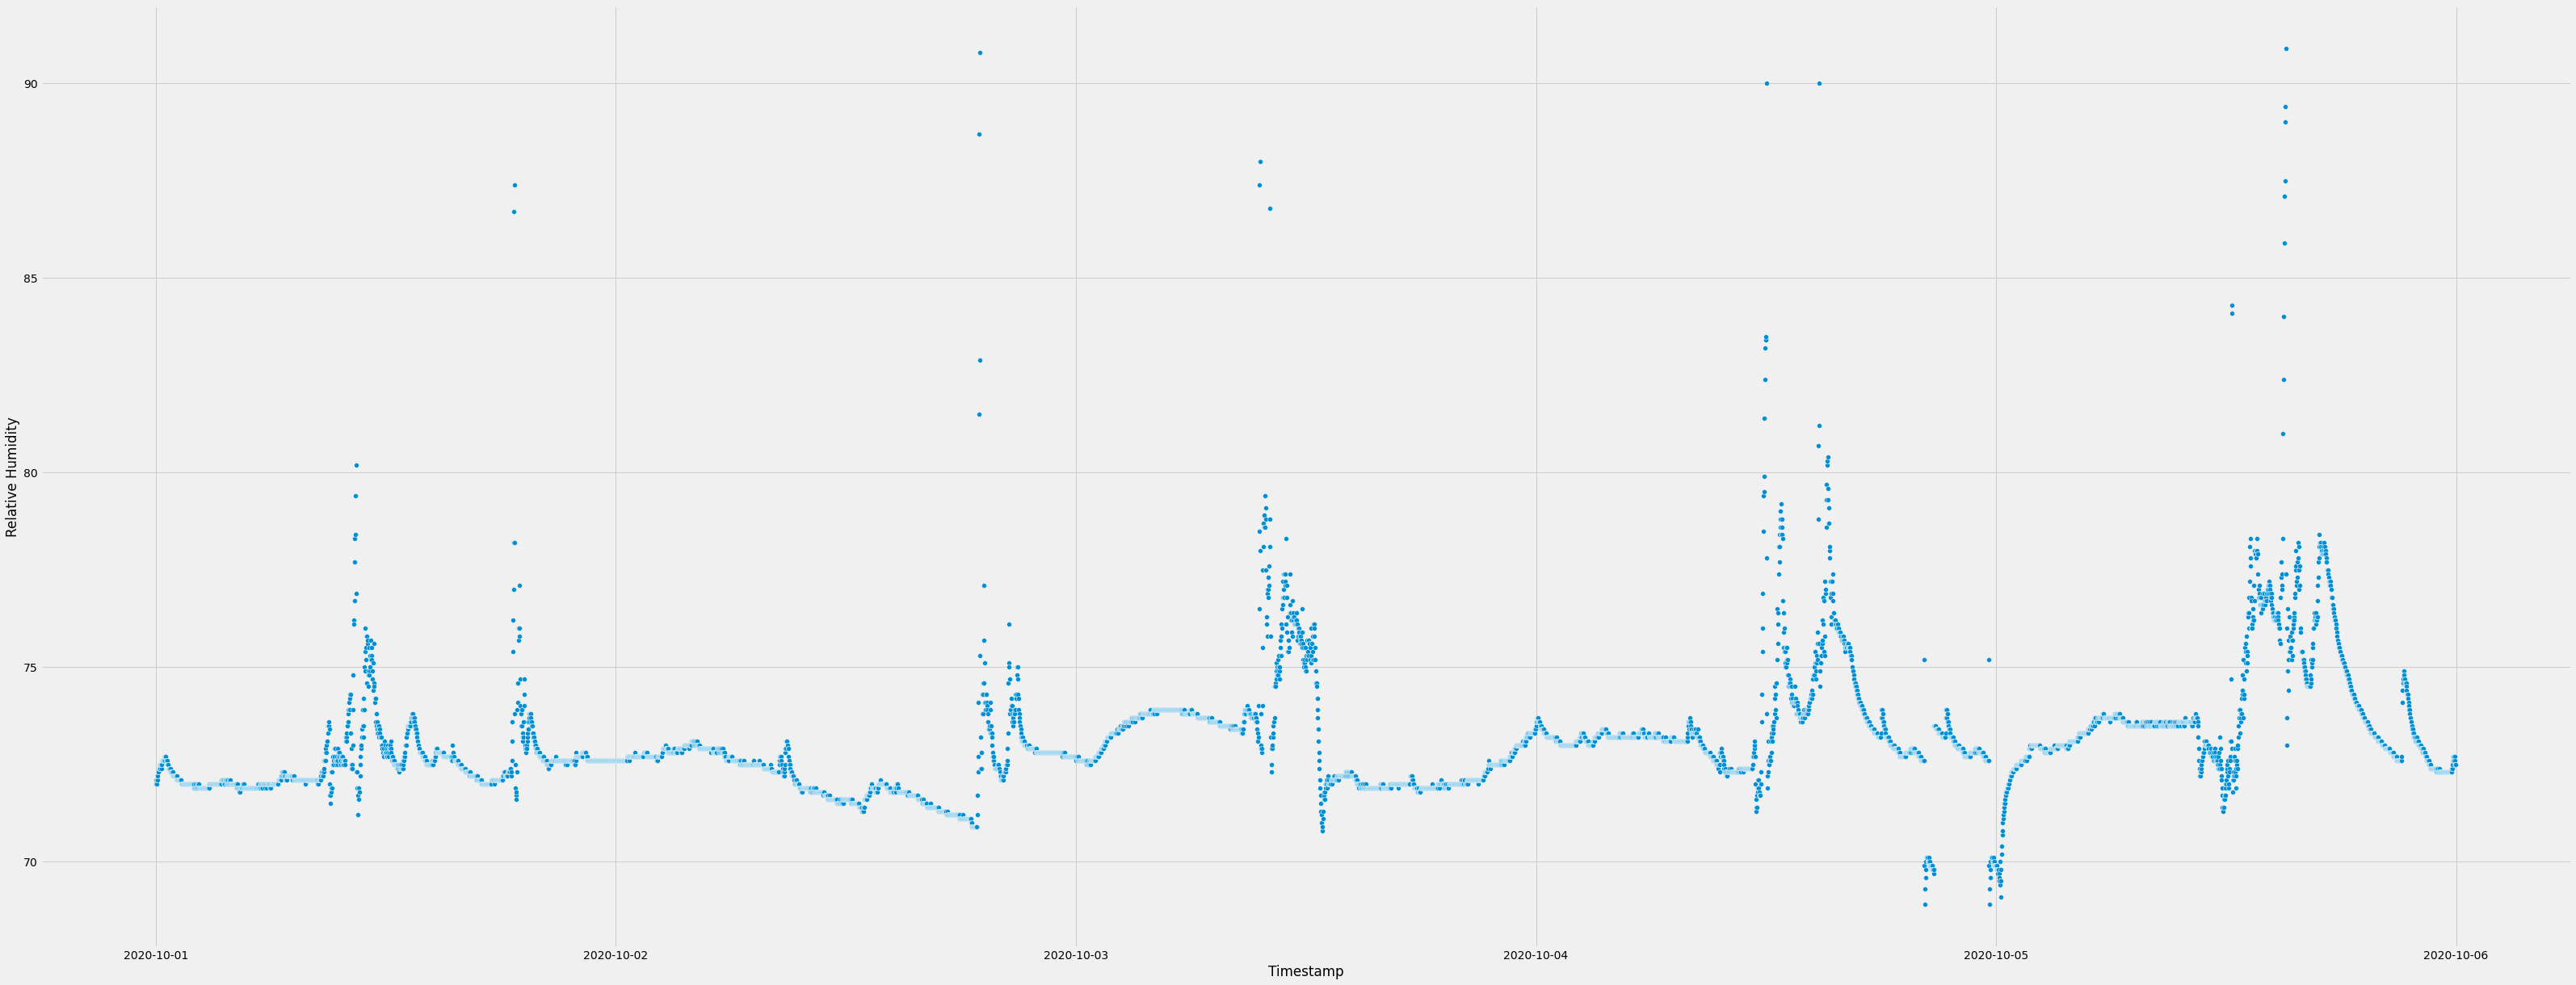

In [36]:
#Scatterplot showing the data for the first five days of October

october_df = df[(df['Time'].dt.year == 2020) & (df['Time'].dt.month == 10)  & (df['Time'].dt.day <= 5)]

# Create the scatter plot
plt.figure (figsize=(50, 20))
sns.scatterplot(x='Time', y='Relative_Humidity', data=october_df)
plt.xlabel('Timestamp')
plt.ylabel('Relative Humidity')
plt.show()

<ipython-input-51-29708a90ba2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  october_df['Duration'] = october_df['Duration']/(60*60)


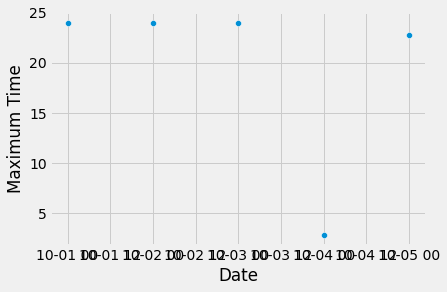

In [51]:
#Display the duration per day
df_results['Date'] = pd.to_datetime(df_results['Date'],format='%Y-%m-%d')
october_df = df_results[(df_results['Date'].dt.year == 2020) & (df_results['Date'].dt.month == 10)  & (df_results['Date'].dt.day <= 5)]
october_df['Duration'] = october_df['Duration']/(60*60)
# Create the scatter plot

sns.scatterplot(x='Date', y='Duration', data=october_df)
plt.xlabel('Date')
plt.ylabel('Maximum Time')
plt.show()